## AWS SageMaker XGBoost Classification Training Models using native XGBoost CV for cross validation Experiment (Features and Parameters research)

Purpose: Based on the configured list of features and/or parameters train several models to compare results. Native XGBoost CV function is used to perform cross validation.

The idea is to do a **deep**  model comparison with the same method (XGBoost Classification), target variable and dataset but different sets of features and/or parameters. 

The models can be trained in parallel and even with a large dataste, the result is available relatively soon comparing to sequntial run on a local server.

The output is not just a model and score but also feature importance, test dataset evaluation score and training/validation errors to analyze overfitting.

OpenSource XGBoost is used in the script and it can NOT be replaced with SageMaker built-in XGBoost. 

The advantage of using this notebook over the previoust one (02.AWS... Training Models with cross validation) is less complex data preparation step (we do not need to create folds in advance) and less parallel running training jobs. If each training job is short one, we do not spend time to create an additional instance. There is also a limit on parallel running large instances in AWS which can be easily approach in complex experiment configurations.

Also, it's only one way, which can be used to do Hyperparameters tuning with CV in AWS as I understand the process as for now.

#### Custom training script output

CV output looks different from training output even if we use  standard XGBoost metrics (ROC-AUC). There is "test" instead of "validation": 
[1060]#011train-auc:0.72230+0.00097#011test-auc:0.69244+0.01114

As a result, the script works, models trains, but to get the CV result from the script we need to implement our own proces to return results via files in S3 or any other approach you may think about. AWS SageMaker monitoring systems, charts and experiments do not recognize the output.

There are 2 approaches to make AWS SageMaker fully functional:
 - Adjust callback functions output in CV to make it identical to the train output. This is relatively simple option. We may even use a custom evaluation function, just name it like a standard function: accuracy, auc, etc 
 - Register custom metrics with metric_defintions (https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html#define-train-metrics-sdk).
 
Note: there is no a mandatory need to implement one of the 2 approached if you are NOT interested in AWS SageMaker monitoring functionality. If the creation of a callback function or a custom ECR repository (see below) for custom metrics are too complex you can skip them and just use output files with CV results in S3.
 
As on Mar/2021 open source, script mode, AWS SageMaker XGBoost is still recognized like a standard, built-in algorithm and prevent us using custom metric definitions.
See https://github.com/aws/sagemaker-xgboost-container/issues/121

The workaround is to create your own container from the official AWS Sagemaker Open Source XGBoost GitHub repository, host it in your own ECR repository, and use this image from Python SDK. 

**Steps to create your own ECR repository:**

1. Install and configure aws-cli (https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-install.html and https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html)

2. Install docker (https://docs.docker.com/engine/install/ubuntu/) or just add your user to the docker group (Some steps below do not work when docker used via sudo)
- sudo usermod -aG docker kate
Activate the changes to groups
- newgrp docker
Verify that you can run docker commands without sudo
- docker run hello-world
3. Build container
- git clone https://github.com/aws/sagemaker-xgboost-container
- docker build -t xgboost-container-base:1.2-1-cpu-py3 -f docker/1.0-1/base/Dockerfile.cpu .
- python setup.py bdist_wheel --universal
- docker build -t preprod-xgboost-container:1.2-1-cpu-py3 -f docker/1.2-1/final/Dockerfile.cpu .
4. Create ECR repository and push the above image.
- eval $(aws ecr get-login --region  us-west-2 --no-include-email | sed 's|https://||')
- aws ecr create-repository --repository-name sagemaker-xgboost --region us-west-2
- docker tag preprod-xgboost-container:1.2-1-cpu-py3 XYZ.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.2-1-cpu-py3
- docker push XYZ.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.2-1-cpu-py3
5. Use image_uri=XYZ.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.2-1-cpu-py3 in XGBoost()


#### Notebook Main steps:

1. Experiment configuration. Instead of hardcoding datafile name, target variable, featuresets and parameters sets directly in the code I use an Excel file. Each tab with a predefined name contains featuresets for each model or parameter sets, etc. At the end, the code records the results back into the same excel file. Excel is used as an UI to easily configure experiment and simplify re-use of this notebook

AWS SageMaker Experiment is used also but I did not find it's very useful to track the featuresets, processing and visaulaize the results (available in SageMaker notebook).  I need to average data before comparing and take into account sem.

2. Preparing training and validation datasets - data preprocessing - in S3 in a format suitable for AWS Sagemaker. SKLearnProcessor and a processing job are used to create all datasets for all models in one process but the same can be done directly in the script and only the result can be moved to S3. If the datasets can be re-used from a previous experiment, only S3 location to the files can be configured instead.
Usually, testing different featuretests requires creation individual datasets per testing model and different parameters can be tested on the same dataset.

Folds are NOT created at this moment. It's done in XGBoost CV.

3. CV for each model is done in parallel. The number of simultaneously running training jobs is contolled by a parameter (MaxNumOfRunningModels).

4. Extracting results, visualization, performing t-test and saving to an experiment log file. This is done for averaged results from all folds per model. 


#### Known issues:
1. Warnings after upgrading SageMaker to version 2:
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
Looks like warnings from XGBoost open-source estimator. No clear information about the parameters
2. All models artifacts (debugging info) are saved into output_path provided as a parameter to the estimator (expected only model.tar.gz) except source/sourcedir.tar.gz which is saved into root of a bucket from output_path. Previously everything except model.tar.gz was saved into default bucket. This is entry_point (training) script and the path is defined in SM_MODULE_DIR environment variable but there is no clue how to change it. 
3. As on Mar/2021 open source, script mode, AWS SageMaker XGBoost is still recognized like a standard, built-in algorithm and prevent us using custom metric definitions.
See https://github.com/aws/sagemaker-xgboost-container/issues/121

In [1]:
temp_folder='/home/kate/Research/YearBuilt/Notebooks/Experiments_v2/tmp/'
#Experiment_name must NOT contain underscore (_)
Experiment_name='subsample'
#Experiments log file
Experiments_file='/home/kate/Research/YearBuilt/Experiments/TestExperiments.xlsx'
#AllExperiments_tab is a table with a list of all experiments included in the log
#Mandatory columns: Experiment (Experiment_name), Dataset(data file name), Target(target column name from Dataset)
#The rest of the columns are not use in the code below. I usually add in a free form: objective,status,result,notebook name used to conduct the experiment
AllExperiments_tab='Experiments'
#Experiment configuration:
#1.Experiment_Features_tab: differenet datasets to try
#each line in the tab contains a model name and set of features to built a dataset for SageMaker
#a feature can be an exact column name from the Dataset column in AllExperiments_tab or a calculation based on exact column names and eval pandas function
#if the experiment objective is to try different parameters sets, all models (if more then 1) can have the same feature sets.
Experiment_Features_tab='%s Features'%Experiment_name
#2. Alternatively a set of data files with preprocessed data in S3 can be provided in a form:
#Model,Training_data,Validation_data[, Testing_data, Testing_labels]
Experiment_InputData_tab='%s InputData'%Experiment_name
#3. Experiment_Params_tab: each line in the tab contains a model name and set of XGBoost parametersto apply to a model
#the set of models should be consistent in Experiment_Features_tab and Experiment_Params_tab
#parameters can be the same for all models or specific in each model
Experiment_Params_tab='%s Params'%Experiment_name

#Trial names in AWS Sage Maker experiment
Trial_name_preprocessing='%s-PreparingTrainValidData'%Experiment_name
Trial_name_training='%s-TrainingModels'%Experiment_name

#everything stored in
bucket='kdproperty'

path_to_data='Data'
path_to_training_data='Data/Experiments/%s/training'%Experiment_name
path_to_validation_data='Data/Experiments/%s/validation'%Experiment_name
path_to_testing_data='Data/Experiments/%s/testing'%Experiment_name
path_to_testing_labels='Data/Experiments/%s/labels'%Experiment_name
path_to_configuration='Config'
path_to_models='Models/Experiments/%s'%Experiment_name

#preprocessing parameters
split_year='2020'

#entry_point defines a script to be run for model training
#the scripts have different ouput and metric defnitions should be adjusted accordingly
entry_point='ModelCV.py' #uses XGBoost CV to return the final, standard, evaluation metric - auc. Use custom image_uri and metric defnitions. 
# ModelCV_Gini_EvalMetric.py uses XGBoost CV with custom evaluation metric - gini. Use custom image_uri and metric defnitions. 


#just a placeholder. the parameter can be commented in XGBoostbor just leave it as empty string. It's used when standard metrics are used.
stnadard_image_uri=''
#it's needed as a workaround to be able to work with custom metrics and scripts output in AWS Sagemaker montitor systems, charts and experiment
custom_image_uri='XYZ.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.2-1-cpu-py3'


#number of folds for CV
num_folds='10'



#level of details returning from CV
#any Y return models from a best iteration
#FeatureImportance Y/N
GetFIFlg='N'
#Scores for Test data (should be provided in fit "test" input) Y/N
GetTestScoreFlg='N'
#Prediction of Test data (should be provided in fit "test" input) Y/N
GetTestPredFlg='N'  


#Confidence level for t-test
confidence_level=0.05

preprocessing_instance_type='ml.t3.large'
preprocessing_instance_count=1

#Training parameters
training_instance_type='ml.c5.xlarge'
training_instance_count=1

#How many simultaneously running training jobs we want to see in the system
MaxNumOfRunningModels = 30
#when a job is completes/failed or stopped a new one can be added Jobs status is checked periodically
check_training_job_every_sec=10

#What to do with th2 experiment (rest of running jobs) if a training job failed or stopped
StopOnFailedModel = True

In [2]:
import sys
import time
import os

import re

import pandas as pd
import numpy as np

import boto3

import s3fs
import tarfile

from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

import sagemaker
from sagemaker.session import TrainingInput
from sagemaker.xgboost.estimator import XGBoost

from sagemaker.analytics import ExperimentAnalytics

#for analyzing results: charts and t-test
import scipy.stats as stats
from matplotlib import pyplot as plt

In [3]:
#should be run as a first step
#role arn is used when run from a local machine
sagemaker_execution_role = 'arn:aws:iam::XYZ:role/service-role/AmazonSageMaker-ExecutionRole-20200819T131882'

region = boto3.session.Session().region_name
sagemaker_session = sagemaker.session.Session()
s3 = s3fs.S3FileSystem()


## Experiment
Experiment is configured in an experiment log file (Excel file, in my case,  in different tabs)

1. Reading an experiment configuration (Experiment_name) from an experiment log file (Experiments_file). Target and Dataset columns in AllExperiments_tab contain data file name used and target column

In [4]:
experiments = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=AllExperiments_tab)

In [5]:
target=experiments[experiments['Experiment']==Experiment_name]['Target'].values[0]
print('Target of models in %s experiment is %s'%(Experiment_name,target))
data_file=experiments[experiments['Experiment']==Experiment_name]['Dataset'].values[0]
print('Datafile used in %s experiment is %s'%(Experiment_name,data_file))

Target of models in subsample experiment is hasclaim_water
Datafile used in subsample experiment is dwelling_basedata_v4.csv


2. Models based on individual datasets to be created, trained and compared in the experiment (Experiment_Features_tab) is a table with first column Model name (should be unique) and next columns [1:51] features to train the model. Feature is the exact column name from the dataset or a calculation based on exact column names and eval pandas function

This configuration will be used to preprocess data and also need to be moved to S3 in csv format for easy reading in a preprocessing script if we use AWS SKLearnProcessor/job/instances

In [6]:
model_features = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_Features_tab)
model_features  

,Model,F1,F2,F3,F4,F5,F6
0,BaseModel,cal_year-yearbuilt,cova_deductible,sqft,water_risk_3_blk,NaN,NaN


In [7]:
#we may need to get mapping between f0 - fN features in the dataset and feature importance output based on Modelname
def GetMap(model):
    feature_map={}
    df=model_features[model_features['Model']==model].loc[:, model_features.columns != 'Model']
    for i,c in enumerate(df.columns):
        feature_map['f%s'%i]=df[c].values[0]
    return feature_map

2a.Preprocessed data may already exists in an S3. Experiment configuration can provide the list of files per model. In this case (len(preprocessed_data)==0) the code skips all steps to preprocess data

In [8]:
try:
    preprocessed_data = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_InputData_tab)
    #preprocessed_data = pd.concat([preprocessed_data,model_features.drop('Model',axis=1)], axis=1)
    preprocessed_data  
except:
    preprocessed_data = pd.DataFrame()

2b.Saving into S3 models configurations (sets of features) to be used in data preprocessing

In [9]:
if len(preprocessed_data)==0:
    Model_Config_file='%s.csv'%Experiment_name
    Models_Config_path = os.path.join(temp_folder, Model_Config_file) 

    model_features.to_csv(Models_Config_path, header=True, index=False)


    input_code = sagemaker_session.upload_data(
        Models_Config_path,
        bucket=bucket,
        key_prefix=path_to_configuration
    )

3. Model params to be used in training is a table with first column Model name (should be unique and corresponds to models in Experiment_Features_tab) and next columns are XGBoost parameters
In a general case, all models can have the same parameters

In [10]:
model_params = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_Params_tab)
model_params

,Model,objective,eval_metric,booster,scale_pos_weight,colsample_bylevel,colsample_bytree,eta,max_depth,num_round,subsample
0,BaseModel,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,3,5000,0.6


4.Verification if we have the same set of models in both configurations

In [11]:
models_from_model_features=model_features['Model'].tolist()
models_from_model_params=model_params['Model'].tolist()
if len([x for x in models_from_model_features if x not in models_from_model_params])!=0:
    raise Exception('Different set of models in featuresets and parametersets!')
if len(preprocessed_data)>0:
    models_from_preprocessed_data=preprocessed_data['Model'].tolist()
    if len([x for x in models_from_preprocessed_data if x not in models_from_model_params])!=0:
        raise Exception('Different set of models in input data and parametersets!')

5.Creating experiments and trials in SageMaker

In [12]:
#sys.path.append('/home/kate/Research/YearBuilt/Notebooks/Experiments')
import ExperimentsUtils as eu

In [13]:
eu.cleanup_experiment(Experiment_name)
eu.create_experiment(Experiment_name)
eu.create_trial(Experiment_name,Trial_name_preprocessing)
eu.create_trial(Experiment_name,Trial_name_training)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials

## Data preprocessing

1. We may not need an AWS SKLearnProcessor/job/instances for relatively small and medium datasets (unless our data are already in S3 and it takes time and money to download)
What's important is to save the prepared datasets in a predefined S3 location to be used in training.
In a case of really huge datasets and instensive, time consuming preprocessing, a separate SKLearnProcessor/job for each model can be created with more then 1 powerful instance.

Preprocessing script below reads the data from the input dataset, model configurations (desired featuresets), seprate 2020 (split_year) as a test dataset (not used in the experiment, because the data may be not complete developed in the year). I does NOT split the rest of the data to training and validation folds because this is what XGBoost CV will do. 

The datasets are saved in AWS SageMaker form (first column is a target, no header) in csv format. The location and filenames are based on model names: folder name is a model name and file names also contain a model name.

In [14]:
%%writefile preprocessing_for_cv_all_models.py

#Training and Validation dataset for SageMaker are the same structure: no headers, the first column is a target and the rest are features


import argparse
import os
import pandas as pd
import numpy as np

if __name__=='__main__':
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_file', type=str)
    parser.add_argument('--split_year', type=int)        
    parser.add_argument('--target', type=str)      
    parser.add_argument('--config_file', type=str)     
    args, _ = parser.parse_known_args()    
    print('Received arguments {}'.format(args))
    
   
    target_column=args.target
    input_data_path = os.path.join('/opt/ml/processing/input', args.data_file)
    config_data_path = os.path.join('/opt/ml/processing/config', args.config_file)
    
    print('Reading input data from {}'.format(input_data_path))
    dataset = pd.read_csv(input_data_path, error_bad_lines=False, index_col=False)
    dataset_test=dataset[(dataset.cal_year == args.split_year)]
    dataset=dataset[(dataset.cal_year < args.split_year)]    
    

    print('Reading config data from {}'.format(config_data_path))
    models = pd.read_csv(config_data_path, error_bad_lines=False, index_col=False)    
    

    #iterating thru config file with models and featureset
    for index, row in models.iterrows():
        model=row['Model']
        print (index, ': Creating datasets for model %s'%model)
        featureset=row[1:51].tolist()
        featureset=[x for x in featureset if str(x) != 'nan']
        print(','.join(featureset))
        
        #creating dataset for a model according to configured dataset
        X = pd.DataFrame()
        X_test = pd.DataFrame()        
        for f in featureset:
            X[f]=dataset.eval(f)
            X_test[f]=dataset_test.eval(f)            
        y=dataset.eval(target_column)
        y_test=dataset_test.eval(target_column) 
        
        #Testing data starts from y_test because they are read in XGBoost processing script to DMatrix amd first column is separated anyway
        #Without the column the script can not predict
        print('Testing data...')
        test_data_output_path = '/opt/ml/processing/output/testing_data/%s/'%model              
        if not os.path.exists(test_data_output_path):
            os.makedirs(test_data_output_path)       
        test_data_output_path = os.path.join(test_data_output_path,  'testing_%s.csv'%(model))  
        test_dataset=pd.DataFrame({target_column:y_test}).join(X_test)
        test_dataset.to_csv(test_data_output_path, header=False, index=False)
        
        #The rest of teh data will be used in cv-fold as a whole and seprated to training/validation insode cv
        X_train = X
        y_train = y
        
        print('Train data...')        
        if not os.path.exists('/opt/ml/processing/output/training_data/%s'%model):
            os.makedirs('/opt/ml/processing/output/training_data/%s'%model)
        train_data_output_path = os.path.join('/opt/ml/processing/output/training_data/%s'%model, 'training_%s.csv'%model) 
        
        training_dataset=pd.DataFrame({target_column:y_train}).join(X_train)
        training_dataset.to_csv(train_data_output_path, header=False, index=False)

Overwriting preprocessing_for_cv_all_models.py


Preprocessing output (training and testing datasets) are saved separately for each model in a folder with the same name as a models name configured in the experiment

In [15]:
if len(preprocessed_data)==0:
    data_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=sagemaker_execution_role,
                                     instance_type=preprocessing_instance_type,
                                     instance_count=preprocessing_instance_count)    
    data_processor.run(code='preprocessing_for_cv_all_models.py',
                            inputs=[ProcessingInput(input_name='data',source='s3://%s/%s/%s'%(bucket,path_to_data,data_file),destination='/opt/ml/processing/input'),
            ProcessingInput(input_name='config',source='s3://%s/%s/%s'%(bucket,path_to_configuration,Model_Config_file),destination='/opt/ml/processing/config'),
                                   ],
                        outputs=[ProcessingOutput(output_name='training_data', source='/opt/ml/processing/output/training_data',destination='s3://%s/%s/'%(bucket,path_to_training_data)),                                 
                                 ProcessingOutput(output_name='testing_data', source='/opt/ml/processing/output/testing_data',destination='s3://%s/%s/'%(bucket,path_to_testing_data)),                                                                                                                                                                                                                       
                                ],
                        arguments=['--data_file',data_file,
                                 '--split_year',split_year,
                                 '--target',target,                                    
                                 '--config_file',Model_Config_file],
                        experiment_config = {
        'ExperimentName': Experiment_name ,
        'TrialName' : Trial_name_preprocessing,
        'TrialComponentDisplayName' : '%s-%s'%(Trial_name_preprocessing,'-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())),},
                    wait=True
                     )
else:
    print('Data already preprocessed in S3')

Data already preprocessed in S3


In [16]:
#in a case a previous step started preproceesin (nothing provided in InputData) Stop the execution if there is an issue with creating input data for the models
if len(preprocessed_data)==0:
    job_name=data_processor.jobs[-1].describe()['ProcessingJobName']
    if not(sagemaker_session.was_processing_job_successful(job_name)):
        raise Exception('Preprocessing job Failed!')    

2. Preprocessing output is saved separately for each model in a folder with the same name as a models name configured in the experiment

In [17]:
if len(preprocessed_data)==0:
    preprocessed_data = pd.DataFrame(columns=['Model', 'Training_data',  'Testing_data'])
    for index, row in model_features.iterrows():
        model=row['Model']
        train_input = 's3://%s/%s/%s/'%(bucket,path_to_training_data,model)
        test_data = 's3://%s/%s/%s/testing_%s.csv'%(bucket,path_to_testing_data,model,model)
        preprocessed_data.loc[index]=[model, train_input,test_data]
    preprocessed_data = pd.concat([preprocessed_data,model_features.drop('Model',axis=1)], axis=1)    
    #Saving into the Experiment log file names of created training and validation datasets in S3
    eu.SaveToExperimentLog(Experiments_file, '%s InputData'%Experiment_name, preprocessed_data)

In [18]:
preprocessed_data

,Model,Training_data,Testing_data,F1,F2,F3,F4,F5,F6
0,BaseModel,s3://kdproperty/Data/Experiments/subsample/tra...,s3://kdproperty/Data/Experiments/subsample/tes...,cal_year-yearbuilt,cova_deductible,sqft,water_risk_3_blk,NaN,NaN


## Model training

1. Custom script to train a model. It's requred for open-source SageMaker XGBoost container used further in the notebook. The script returns some additional information (feature importance, test dataset scores and train/validation errors) from training for custom processing.  The script uses a call back function to access the models and return them from the function. The models are needed for feature importance, predict and score test data. The first model is saved as model.tar.gz as in a usual training job. All models are saved in output.tar.gz with the rest of the additional data.
- ModelCV.py uses standard XGBoost evaluation metric(AUC) in CV
- ModelCV_Gini_EvalMetric.py uses custome evaluation metric(gini) in CV
You need just one script, configured in entry_point above, and used in XGBoost below

In [43]:
%%writefile ModelCV.py
#ModelCV.py uses standard XGBoost evaluation metric(AUC) in CV




import argparse
import json
import logging
import os
import pandas as pd
import pickle as pkl

from sagemaker_containers import entry_point
from sagemaker_xgboost_container.data_utils import get_dmatrix
from sagemaker_xgboost_container import distributed

import xgboost as xgb

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score

import re

def cv_misc_callback(oof_train_scores:list, oof_valid_scores:list, best_models:list, NeedModelsFlg='N', maximize=True):
    """
    It's called inside XGB CV to catch individual folds scores
    """    
    state = {}
    def init(env):
        if maximize:
            state['best_score'] = -np.inf
        else:
            state['best_score'] = np.inf 
    def callback(env):
        #fold best model if flag
        if NeedModelsFlg=='Y':
            if not state:
                init(env)
            best_score = state['best_score']
            score = env.evaluation_result_list[-1][1]
            if (maximize and score > best_score) or (not maximize and score < best_score):
                for i, cvpack in enumerate(env.cvfolds): 
                    best_models[i]=cvpack.bst
                state['best_score'] = score    
        #all iterations folds scores
        folds_train_scores = []
        folds_valid_scores = []
        for i, cvpack in enumerate(env.cvfolds):
            scores = cvpack.eval(iteration=0,feval=None)
            scores_l = re.split(': |\t',scores)
            train_score=scores_l[1].rpartition(':')[2]
            valid_score=scores_l[2].rpartition(':')[2]
            folds_train_scores.append(train_score)
            folds_valid_scores.append(valid_score)
        oof_train_scores.append(folds_train_scores)
        oof_valid_scores.append(folds_valid_scores)
    callback.before_iteration = False
    return callback

def _xgb_cv(params, dtrain,  num_boost_round, nfold, early_stopping_rounds, model_dir, output_data_dir, GetFIFlg,GetTestScoreFlg,GetTestPredFlg,is_master):
    """Run xgb cv on arguments given with rabit initialized.

    This is our rabit execution function.

    :param args_dict: Argument dictionary used to run xgb.train().
    :param is_master: True if current node is master host in distributed training,
                        or is running single node training job.
                        Note that rabit_run will include this argument.
    """
    oof_train_scores = []
    oof_valid_scores = []
    best_models=[None]*nfold
    NeedModelsFlg = 'Y' if 'Y' in (GetFIFlg,GetTestScoreFlg,GetTestPredFlg) else 'N'
    cv_results=xgb.cv(params, dtrain, num_boost_round=num_boost_round,
                 nfold=nfold, stratified=True, shuffle=True,early_stopping_rounds=early_stopping_rounds, seed=42
                      ,callbacks=[cv_misc_callback(oof_train_scores, oof_valid_scores,best_models,NeedModelsFlg,True), xgb.callback.print_evaluation(period=20)]
                     )



    #scores to dataframe
    df_oof_train_scores = pd.DataFrame.from_records(oof_train_scores).apply(pd.to_numeric)
    df_oof_valid_scores = pd.DataFrame.from_records(oof_valid_scores).apply(pd.to_numeric)


    
    #only folds scores columns names
    columns = df_oof_train_scores.columns.tolist()

    
    #mean and std, sem 
    df_oof_train_scores['std'] = df_oof_train_scores[columns].std(axis=1)
    df_oof_valid_scores['std'] = df_oof_valid_scores[columns].std(axis=1)
    df_oof_train_scores['sem'] = df_oof_train_scores[columns].sem(axis=1)
    df_oof_valid_scores['sem'] = df_oof_valid_scores[columns].sem(axis=1)    
    df_oof_train_scores['mean'] = df_oof_train_scores[columns].mean(axis=1)
    df_oof_valid_scores['mean'] = df_oof_valid_scores[columns].mean(axis=1)
    
    #best models feature importance 
    if GetFIFlg=='Y':
        oof_fi_weight_best = {}
        oof_fi_gain_best = {}
        oof_fi_cover_best = {}
        for i in range(0,nfold):
            oof_fi_weight_best[i]=best_models[i].get_score(importance_type='weight')
            oof_fi_gain_best[i]= best_models[i].get_score(importance_type='gain')
            oof_fi_cover_best[i]= best_models[i].get_score(importance_type='cover')
    
        #converting to dataframe
        df_oof_fi_weight_best = pd.DataFrame(oof_fi_weight_best).apply(pd.to_numeric)
        df_oof_fi_gain_best = pd.DataFrame(oof_fi_gain_best).apply(pd.to_numeric)
        df_oof_fi_cover_best = pd.DataFrame(oof_fi_cover_best).apply(pd.to_numeric)
    
    
        #mean and std, sem 
        df_oof_fi_weight_best['std'] = df_oof_fi_weight_best[columns].std(axis=1)
        df_oof_fi_gain_best['std'] = df_oof_fi_gain_best[columns].std(axis=1)
        df_oof_fi_cover_best['std'] = df_oof_fi_cover_best[columns].std(axis=1)
    
        df_oof_fi_weight_best['sem'] = df_oof_fi_weight_best[columns].sem(axis=1)
        df_oof_fi_gain_best['sem'] = df_oof_fi_gain_best[columns].sem(axis=1)
        df_oof_fi_cover_best['sem'] = df_oof_fi_cover_best[columns].sem(axis=1)
    
        df_oof_fi_weight_best['mean'] = df_oof_fi_weight_best[columns].mean(axis=1)
        df_oof_fi_gain_best['mean'] = df_oof_fi_gain_best[columns].mean(axis=1)
        df_oof_fi_cover_best['mean'] = df_oof_fi_cover_best[columns].mean(axis=1)
    
    
        #feature codes from index to column
        df_oof_fi_weight_best.reset_index(level=0, inplace=True)
        df_oof_fi_weight_best.columns=['feature'] + columns + ['std','sem','mean']
        df_oof_fi_gain_best.reset_index(level=0, inplace=True)
        df_oof_fi_gain_best.columns=['feature'] + columns + ['std','sem','mean']
        df_oof_fi_cover_best.reset_index(level=0, inplace=True)
        df_oof_fi_cover_best.columns=['feature'] + columns + ['std','sem','mean']
    
    if 'Y' in (GetTestScoreFlg,GetTestPredFlg):
        #Prediction on test data  from folds best models...
        df_prediction=pd.DataFrame()
        df_prediction['actual']=dtest.get_label()
        for i in range(0,nfold):
            df_prediction[i]=best_models[i].predict(dtest)
   
        #Test scores from test prediction   
        df_scores = pd.DataFrame()
        for i in range(0,nfold):
            df_scores[i]=[roc_auc_score(df_prediction['actual'], df_prediction[i])]

        df_scores['std'] = df_scores[columns].std(axis=1)
        df_scores['sem'] = df_scores[columns].sem(axis=1)
        df_scores['mean'] = df_scores[columns].mean(axis=1)

    if is_master:
        if not os.path.exists(output_data_dir):
            os.makedirs(output_data_dir)
            
        if NeedModelsFlg == 'Y':
            model_location = model_dir + '/xgboost-model'
            pkl.dump(best_models[0], open(model_location, 'wb'))
            print('Stored best model from 1st fold at {}'.format(model_location))
            logging.info('Stored best model from 1st fold at {}'.format(model_location))        
               
            print('Stored best models from all folds at {}'.format(output_data_dir))
            logging.info('Stored best models from all folds at {}'.format(output_data_dir))
        
            for i in range(0,nfold):
                model_location = output_data_dir + '/xgboost-model-fold'+str(i)
                pkl.dump(best_models[i], open(model_location, 'wb'))
        
        if  GetTestPredFlg=='Y':    
            predictions_location = os.path.join(output_data_dir, 'test_predictions.csv')
            print('Saving test predictions at {}'.format(predictions_location))
            logging.info('Saving test predictions at {}'.format(predictions_location))            
            df_prediction.to_csv(predictions_location, header=True, index=False)
        
        if  GetTestScoreFlg=='Y':
            oof_test_scores_location = os.path.join(output_data_dir, 'oof_test_scores.csv')
            print('Saving oof_test_scores at {}'.format(oof_test_scores_location))
            logging.info('Saving oof_test_scores at {}'.format(oof_test_scores_location))
            df_scores.to_csv(oof_test_scores_location, header=True, index=False)
        
        cv_result_location = os.path.join(output_data_dir, 'cv_results.csv')
        print('Saving cv results at {}'.format(cv_result_location))
        logging.info('Saving cv results at {}'.format(cv_result_location))
        cv_results.to_csv(cv_result_location, header=True, index=False)
        
        oof_train_scores_location = os.path.join(output_data_dir, 'oof_train_scores.csv')
        print('Saving oof_train_scores at {}'.format(oof_train_scores_location))
        logging.info('Saving oof_train_scores at {}'.format(oof_train_scores_location))
        df_oof_train_scores.to_csv(oof_train_scores_location, header=True, index=False)  
        
        oof_valid_scores_location = os.path.join(output_data_dir, 'oof_valid_scores.csv')
        print('Saving oof_valid_scores at {}'.format(oof_valid_scores_location))
        logging.info('Saving oof_valid_scores at {}'.format(oof_valid_scores_location))
        df_oof_valid_scores.to_csv(oof_valid_scores_location, header=True, index=False)
        
        if  GetFIFlg=='Y':
            oof_fi_weight_best_location = os.path.join(output_data_dir, 'oof_fi_weight_best.csv')
            print('Saving oof_fi_weight_best at {}'.format(oof_fi_weight_best_location))
            logging.info('Saving oof_fi_weight_best at {}'.format(oof_fi_weight_best_location))
            df_oof_fi_weight_best.to_csv(oof_fi_weight_best_location, header=True, index=False)  
        
            oof_fi_gain_best_location = os.path.join(output_data_dir, 'oof_fi_gain_best.csv')
            print('Saving oof_fi_gain_best at {}'.format(oof_fi_gain_best_location))
            logging.info('Saving oof_fi_gain_best at {}'.format(oof_fi_gain_best_location))
            df_oof_fi_gain_best.to_csv(oof_fi_gain_best_location, header=True, index=False)        
        
            oof_fi_cover_best_location = os.path.join(output_data_dir, 'oof_fi_cover_best.csv')
            print('Saving oof_fi_cover_best at {}'.format(oof_fi_cover_best_location))
            logging.info('Saving oof_fi_cover_best at {}'.format(oof_fi_cover_best_location))
            df_oof_fi_cover_best.to_csv(oof_fi_cover_best_location, header=True, index=False)  
           
    
    
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here.
    parser.add_argument('--max_depth', type=int,)
    parser.add_argument('--eta', type=float)
    parser.add_argument('--objective', type=str)
    parser.add_argument('--num_round', type=int)
    parser.add_argument('--nfold', type=int)
    parser.add_argument('--early_stopping_rounds', type=int)
    parser.add_argument('--booster', type=str)
    parser.add_argument('--eval_metric', type=str)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--scale_pos_weight', type=float)
    parser.add_argument('--colsample_bylevel', type=float)
    parser.add_argument('--colsample_bytree', type=float)
    parser.add_argument('--subsample', type=float)
    parser.add_argument('--max_delta_step', type=int)
            
            

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    
    parser.add_argument('--output_data_dir', type=str, default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    parser.add_argument('--sm_hosts', type=str, default=os.environ.get('SM_HOSTS'))
    parser.add_argument('--sm_current_host', type=str, default=os.environ.get('SM_CURRENT_HOST'))
    
    parser.add_argument('--GetFIFlg', type=str, default='N')
    parser.add_argument('--GetTestScoreFlg', type=str, default='N')
    parser.add_argument('--GetTestPredFlg', type=str, default='N')
                
                

    args, _ = parser.parse_known_args()

    # Get SageMaker host information from runtime environment variables
    sm_hosts = json.loads(args.sm_hosts)
    sm_current_host = args.sm_current_host

    dtrain = get_dmatrix(args.train, 'csv')
    
    dtest = get_dmatrix(args.test, 'csv')

    if not(dtest):
        if ((args.GetTestScoreFlg=='Y') | (args.GetTestPredFlg=='Y')):
            raise Exception('Please provide test data in a test channel for prediction and scores or set GetTestScoreFlg and GetTestPredFlg to N')

    train_hp = {
        'max_depth': args.max_depth,
        'eta': args.eta,
        'objective': args.objective,
        'booster': args.booster,
        'seed': args.seed,
        'eval_metric':args.eval_metric,
        'scale_pos_weight':args.scale_pos_weight,
        'colsample_bylevel': args.colsample_bylevel,
        'colsample_bytree': args.colsample_bytree,
        'subsample': args.subsample,
        'max_delta_step':args.max_delta_step
        }

    xgb_train_args = dict(
        params=train_hp,
        dtrain=dtrain,
        num_boost_round=args.num_round,
        nfold=args.nfold, 
        early_stopping_rounds=args.early_stopping_rounds,
        model_dir=args.model_dir,
        output_data_dir=args.output_data_dir,
        GetFIFlg=args.GetFIFlg,
        GetTestScoreFlg=args.GetTestScoreFlg,
        GetTestPredFlg=args.GetTestPredFlg
    )

    if len(sm_hosts) > 1:
        # Wait until all hosts are able to find each other
        entry_point._wait_hostname_resolution()

        # Execute training function after initializing rabit.
        distributed.rabit_run(
            exec_fun=_xgb_cv,
            args=xgb_train_args,
            include_in_training=(dtrain is not None),
            hosts=sm_hosts,
            current_host=sm_current_host,
            update_rabit_args=True
        )
    else:
        # If single node training, call training method directly.
        if dtrain:
            xgb_train_args['is_master'] = True
            _xgb_cv(**xgb_train_args)
        else:
            raise ValueError("Training channel must have data to train model.")

Overwriting ModelCV.py


In [42]:
%%writefile ModelCV_Gini_EvalMetric.py
#ModelCV_Gini_EvalMetric.py uses ustome evaluation metric(gini) in CV




import argparse
import json
import logging
import os
import pandas as pd
import pickle as pkl

from sagemaker_containers import entry_point
from sagemaker_xgboost_container.data_utils import get_dmatrix
from sagemaker_xgboost_container import distributed

import xgboost as xgb

import pandas as pd
import numpy as np



def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

import re

def cv_misc_callback(oof_train_scores:list, oof_valid_scores:list, best_models:list, NeedModelsFlg='N', maximize=True):
    """
    It's called inside XGB CV to catch individual folds scores
    """    
    state = {}
    def init(env):
        if maximize:
            state['best_score'] = -np.inf
        else:
            state['best_score'] = np.inf 
    def callback(env):
        #fold best model if flag
        if NeedModelsFlg=='Y':
            if not state:
                init(env)
            best_score = state['best_score']
            score = env.evaluation_result_list[-1][1]
            if (maximize and score > best_score) or (not maximize and score < best_score):
                for i, cvpack in enumerate(env.cvfolds): 
                    best_models[i]=cvpack.bst
                state['best_score'] = score    
        #all iterations folds scores
        folds_train_scores = []
        folds_valid_scores = []
        for i, cvpack in enumerate(env.cvfolds):
            scores = cvpack.eval(iteration=0,feval=gini_xgb)
            scores_l = re.split(': |\t',scores)
            train_score=scores_l[1].rpartition(':')[2]
            valid_score=scores_l[2].rpartition(':')[2]
            folds_train_scores.append(train_score)
            folds_valid_scores.append(valid_score)
        oof_train_scores.append(folds_train_scores)
        oof_valid_scores.append(folds_valid_scores)
    callback.before_iteration = False
    return callback

def _xgb_cv(params, dtrain,  num_boost_round, nfold, early_stopping_rounds, model_dir, output_data_dir, GetFIFlg,GetTestScoreFlg,GetTestPredFlg,is_master):
    """Run xgb cv on arguments given with rabit initialized.

    This is our rabit execution function.

    :param args_dict: Argument dictionary used to run xgb.train().
    :param is_master: True if current node is master host in distributed training,
                        or is running single node training job.
                        Note that rabit_run will include this argument.
    """
    oof_train_scores = []
    oof_valid_scores = []
    best_models=[None]*nfold
    NeedModelsFlg = 'Y' if 'Y' in (GetFIFlg,GetTestScoreFlg,GetTestPredFlg) else 'N'
    cv_results=xgb.cv(params, 
                      dtrain, 
                      feval=gini_xgb,
                      num_boost_round=num_boost_round,
                      nfold=nfold, 
                      stratified=True, 
                      shuffle=True,
                      early_stopping_rounds=early_stopping_rounds, 
                      seed=42,
                      callbacks=[cv_misc_callback(oof_train_scores, oof_valid_scores,best_models,NeedModelsFlg,True), xgb.callback.print_evaluation(period=1)]
                     )



    #scores to dataframe
    df_oof_train_scores = pd.DataFrame.from_records(oof_train_scores).apply(pd.to_numeric)
    df_oof_valid_scores = pd.DataFrame.from_records(oof_valid_scores).apply(pd.to_numeric)


    
    #only folds scores columns names
    columns = df_oof_train_scores.columns.tolist()

    
    #mean and std, sem 
    df_oof_train_scores['std'] = df_oof_train_scores[columns].std(axis=1)
    df_oof_valid_scores['std'] = df_oof_valid_scores[columns].std(axis=1)
    df_oof_train_scores['sem'] = df_oof_train_scores[columns].sem(axis=1)
    df_oof_valid_scores['sem'] = df_oof_valid_scores[columns].sem(axis=1)    
    df_oof_train_scores['mean'] = df_oof_train_scores[columns].mean(axis=1)
    df_oof_valid_scores['mean'] = df_oof_valid_scores[columns].mean(axis=1)
    
    #best models feature importance 
    if GetFIFlg=='Y':
        oof_fi_weight_best = {}
        oof_fi_gain_best = {}
        oof_fi_cover_best = {}
        for i in range(0,nfold):
            oof_fi_weight_best[i]=best_models[i].get_score(importance_type='weight')
            oof_fi_gain_best[i]= best_models[i].get_score(importance_type='gain')
            oof_fi_cover_best[i]= best_models[i].get_score(importance_type='cover')
    
        #converting to dataframe
        df_oof_fi_weight_best = pd.DataFrame(oof_fi_weight_best).apply(pd.to_numeric)
        df_oof_fi_gain_best = pd.DataFrame(oof_fi_gain_best).apply(pd.to_numeric)
        df_oof_fi_cover_best = pd.DataFrame(oof_fi_cover_best).apply(pd.to_numeric)
    
    
        #mean and std, sem 
        df_oof_fi_weight_best['std'] = df_oof_fi_weight_best[columns].std(axis=1)
        df_oof_fi_gain_best['std'] = df_oof_fi_gain_best[columns].std(axis=1)
        df_oof_fi_cover_best['std'] = df_oof_fi_cover_best[columns].std(axis=1)
    
        df_oof_fi_weight_best['sem'] = df_oof_fi_weight_best[columns].sem(axis=1)
        df_oof_fi_gain_best['sem'] = df_oof_fi_gain_best[columns].sem(axis=1)
        df_oof_fi_cover_best['sem'] = df_oof_fi_cover_best[columns].sem(axis=1)
    
        df_oof_fi_weight_best['mean'] = df_oof_fi_weight_best[columns].mean(axis=1)
        df_oof_fi_gain_best['mean'] = df_oof_fi_gain_best[columns].mean(axis=1)
        df_oof_fi_cover_best['mean'] = df_oof_fi_cover_best[columns].mean(axis=1)
    
    
        #feature codes from index to column
        df_oof_fi_weight_best.reset_index(level=0, inplace=True)
        df_oof_fi_weight_best.columns=['feature'] + columns + ['std','sem','mean']
        df_oof_fi_gain_best.reset_index(level=0, inplace=True)
        df_oof_fi_gain_best.columns=['feature'] + columns + ['std','sem','mean']
        df_oof_fi_cover_best.reset_index(level=0, inplace=True)
        df_oof_fi_cover_best.columns=['feature'] + columns + ['std','sem','mean']
    
    if 'Y' in (GetTestScoreFlg,GetTestPredFlg):
        #Prediction on test data  from folds best models...
        df_prediction=pd.DataFrame()
        df_prediction['actual']=dtest.get_label()
        for i in range(0,nfold):
            df_prediction[i]=best_models[i].predict(dtest)
   
        #Test scores from test prediction   
        df_scores = pd.DataFrame()
        for i in range(0,nfold):
            df_scores[i]=[gini_xgb(df_prediction['actual'], df_prediction[i])]

        df_scores['std'] = df_scores[columns].std(axis=1)
        df_scores['sem'] = df_scores[columns].sem(axis=1)
        df_scores['mean'] = df_scores[columns].mean(axis=1)

    if is_master:
        if not os.path.exists(output_data_dir):
            os.makedirs(output_data_dir)
            
        if NeedModelsFlg == 'Y':
            model_location = model_dir + '/xgboost-model'
            pkl.dump(best_models[0], open(model_location, 'wb'))
            print('Stored best model from 1st fold at {}'.format(model_location))
            logging.info('Stored best model from 1st fold at {}'.format(model_location))        
               
            print('Stored best models from all folds at {}'.format(output_data_dir))
            logging.info('Stored best models from all folds at {}'.format(output_data_dir))
        
            for i in range(0,nfold):
                model_location = output_data_dir + '/xgboost-model-fold'+str(i)
                pkl.dump(best_models[i], open(model_location, 'wb'))
        
        if  GetTestPredFlg=='Y':    
            predictions_location = os.path.join(output_data_dir, 'test_predictions.csv')
            print('Saving test predictions at {}'.format(predictions_location))
            logging.info('Saving test predictions at {}'.format(predictions_location))            
            df_prediction.to_csv(predictions_location, header=True, index=False)
        
        if  GetTestScoreFlg=='Y':
            oof_test_scores_location = os.path.join(output_data_dir, 'oof_test_scores.csv')
            print('Saving oof_test_scores at {}'.format(oof_test_scores_location))
            logging.info('Saving oof_test_scores at {}'.format(oof_test_scores_location))
            df_scores.to_csv(oof_test_scores_location, header=True, index=False)
        
        cv_result_location = os.path.join(output_data_dir, 'cv_results.csv')
        print('Saving cv results at {}'.format(cv_result_location))
        logging.info('Saving cv results at {}'.format(cv_result_location))
        cv_results.to_csv(cv_result_location, header=True, index=False)
        
        oof_train_scores_location = os.path.join(output_data_dir, 'oof_train_scores.csv')
        print('Saving oof_train_scores at {}'.format(oof_train_scores_location))
        logging.info('Saving oof_train_scores at {}'.format(oof_train_scores_location))
        df_oof_train_scores.to_csv(oof_train_scores_location, header=True, index=False)  
        
        oof_valid_scores_location = os.path.join(output_data_dir, 'oof_valid_scores.csv')
        print('Saving oof_valid_scores at {}'.format(oof_valid_scores_location))
        logging.info('Saving oof_valid_scores at {}'.format(oof_valid_scores_location))
        df_oof_valid_scores.to_csv(oof_valid_scores_location, header=True, index=False)
        
        if  GetFIFlg=='Y':
            oof_fi_weight_best_location = os.path.join(output_data_dir, 'oof_fi_weight_best.csv')
            print('Saving oof_fi_weight_best at {}'.format(oof_fi_weight_best_location))
            logging.info('Saving oof_fi_weight_best at {}'.format(oof_fi_weight_best_location))
            df_oof_fi_weight_best.to_csv(oof_fi_weight_best_location, header=True, index=False)  
        
            oof_fi_gain_best_location = os.path.join(output_data_dir, 'oof_fi_gain_best.csv')
            print('Saving oof_fi_gain_best at {}'.format(oof_fi_gain_best_location))
            logging.info('Saving oof_fi_gain_best at {}'.format(oof_fi_gain_best_location))
            df_oof_fi_gain_best.to_csv(oof_fi_gain_best_location, header=True, index=False)        
        
            oof_fi_cover_best_location = os.path.join(output_data_dir, 'oof_fi_cover_best.csv')
            print('Saving oof_fi_cover_best at {}'.format(oof_fi_cover_best_location))
            logging.info('Saving oof_fi_cover_best at {}'.format(oof_fi_cover_best_location))
            df_oof_fi_cover_best.to_csv(oof_fi_cover_best_location, header=True, index=False)  
           
    
    
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here.
    parser.add_argument('--max_depth', type=int,)
    parser.add_argument('--eta', type=float)
    parser.add_argument('--objective', type=str)
    parser.add_argument('--num_round', type=int)
    parser.add_argument('--nfold', type=int)
    parser.add_argument('--early_stopping_rounds', type=int)
    parser.add_argument('--booster', type=str)
    parser.add_argument('--eval_metric', type=str)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--scale_pos_weight', type=float)
    parser.add_argument('--colsample_bylevel', type=float)
    parser.add_argument('--colsample_bytree', type=float)
    parser.add_argument('--subsample', type=float)
    parser.add_argument('--max_delta_step', type=int)
            
            

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    
    parser.add_argument('--output_data_dir', type=str, default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    parser.add_argument('--sm_hosts', type=str, default=os.environ.get('SM_HOSTS'))
    parser.add_argument('--sm_current_host', type=str, default=os.environ.get('SM_CURRENT_HOST'))
    
    parser.add_argument('--GetFIFlg', type=str, default='N')
    parser.add_argument('--GetTestScoreFlg', type=str, default='N')
    parser.add_argument('--GetTestPredFlg', type=str, default='N')
                
                

    args, _ = parser.parse_known_args()

    # Get SageMaker host information from runtime environment variables
    sm_hosts = json.loads(args.sm_hosts)
    sm_current_host = args.sm_current_host

    dtrain = get_dmatrix(args.train, 'csv')
    
    dtest = get_dmatrix(args.test, 'csv')

    if not(dtest):
        if ((args.GetTestScoreFlg=='Y') | (args.GetTestPredFlg=='Y')):
            raise Exception('Please provide test data in a test channel for prediction and scores or set GetTestScoreFlg and GetTestPredFlg to N')

    train_hp = {
        'max_depth': args.max_depth,
        'eta': args.eta,
        'objective': args.objective,
        'booster': args.booster,
        'seed': args.seed,
        #'eval_metric':args.eval_metric,
        'disable_default_eval_metric': '1',
        'scale_pos_weight':args.scale_pos_weight,
        'colsample_bylevel': args.colsample_bylevel,
        'colsample_bytree': args.colsample_bytree,
        'subsample': args.subsample,
        'max_delta_step':args.max_delta_step
        }

    xgb_train_args = dict(
        params=train_hp,
        dtrain=dtrain,
        num_boost_round=args.num_round,
        nfold=args.nfold, 
        early_stopping_rounds=args.early_stopping_rounds,
        model_dir=args.model_dir,
        output_data_dir=args.output_data_dir,
        GetFIFlg=args.GetFIFlg,
        GetTestScoreFlg=args.GetTestScoreFlg,
        GetTestPredFlg=args.GetTestPredFlg
    )

    if len(sm_hosts) > 1:
        # Wait until all hosts are able to find each other
        entry_point._wait_hostname_resolution()

        # Execute training function after initializing rabit.
        distributed.rabit_run(
            exec_fun=_xgb_cv,
            args=xgb_train_args,
            include_in_training=(dtrain is not None),
            hosts=sm_hosts,
            current_host=sm_current_host,
            update_rabit_args=True
        )
    else:
        # If single node training, call training method directly.
        if dtrain:
            xgb_train_args['is_master'] = True
            _xgb_cv(**xgb_train_args)
        else:
            raise ValueError("Training channel must have data to train model.")

Overwriting ModelCV_Gini_EvalMetric.py


2. For each parameter set we create an estimator and train it using training and validation datasets created in previous step and saved in a predefined location 
based on Model name. 

The train and valid files locations are saved in preprocessed_data dataframe. They are created for each fold.

Since we built our training jobs based on preconfigured parameters and train/valid locations the data in 2 configuration must be consistent (the same model names).

Only configured number (MaxNumOfRunningModels) of models is running at the same time. The process starts initial MaxNumOfRunningModels models and waits till 
one of them Complete, Failed or Stopped (StopOnFailedModel=False only).
If a model training job Failed or Stopped and StopOnFailedModel is True, the whole process is broken.
Since the training and validation data are created for each fold, the resulting table (data_for_training) will consist data for each configured feature set, parameter set and all folds.
The total number of training jobs is number of featuresets * folds * number of parametersets. It can be huge.

In [20]:
models_from_preprocessed_data=preprocessed_data['Model'].tolist()
models_from_model_params=model_params['Model'].tolist()
if len([x for x in models_from_preprocessed_data if x not in models_from_model_params])!=0:
    raise Exception('Different set of models in preprocessed_data and parametersets!')
#using merge because, in general, we can have different number of rows in each dataframe - folds in data and different sets of params
data_for_training=pd.merge(model_params, preprocessed_data, on='Model', how='inner')
data_for_training

,Model,objective,eval_metric,booster,scale_pos_weight,colsample_bylevel,colsample_bytree,eta,max_depth,num_round,subsample,Training_data,Testing_data,F1,F2,F3,F4,F5,F6
0,BaseModel,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,3,5000,0.6,s3://kdproperty/Data/Experiments/subsample/tra...,s3://kdproperty/Data/Experiments/subsample/tes...,cal_year-yearbuilt,cova_deductible,sqft,water_risk_3_blk,NaN,NaN


If you want to use AWS SageMaker montoring system, charts and AWS SageMaker experiment then custom metrics (CV output is always custom) should be registered. The metrics work only with a custom XGBoost image. See more detail at the top how to create it.
Comment using metric_definitions and image_uri in the next cell (look for xgb_script_mode_estimator = XGBoost) if you are Ok with the custom script output and do not use/need AWS SageMaker monitoring features.

In [21]:
if entry_point=='ModelCV.py':
    #[1060]#011train-auc:0.72230+0.00097#011test-auc:0.69244+0.01114
    metric_definitions = [
    {
        'Name': 'train-auc',
        'Regex': '.*\\[[0-9]+\\].*#011train-auc:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'
    },    
    {
        'Name': 'test-auc',
        'Regex': '.*\\[[0-9]+\\].*#011test-auc:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'
    }
] 
    image_uri=custom_image_uri
elif entry_point=='ModelCV_Gini_EvalMetric.py':    
    #[99]#011train-gini:0.10383+0.08569#011test-gini:0.10243+0.08417
    metric_definitions = [
    {
        'Name': 'train-gini',
        'Regex': '.*\\[[0-9]+\\].*#011train-gini:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'
    },    
    {
        'Name': 'test-gini',
        'Regex': '.*\\[[0-9]+\\].*#011test-gini:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'
    }
]
    image_uri=custom_image_uri
else:
    metric_definitions = []
    image_uri=standard_image_uri

In [22]:
CntRunningInst = 0

processors=list()
training_jobs_names=list()

#regexpression to exclude features (F1..F25) from the list of parameters
regex = re.compile('F[ 0-9]')

for index, row in data_for_training.iterrows():
    model='%s-%s'%(row['Model'],index)
    print(model)
    #1. Verifying training and validation data exists (were created in preprocessing step or moved manually in a predefined location)

    if not(s3.exists(row['Training_data'])):           
        print('Training data does not exist. Skipping model %s'%(model))
        print('Check Training data in %s'%row['Training_data'])             
        continue
    #2. Do we have available instances slots to run the model? It depends on number of allowed in teh account simultaneously running specific instance types,
    #number of instance type configured per model and configured number of model running
    if CntRunningInst >= MaxNumOfRunningModels * training_instance_count: #not enough slots to add a model
        print('There is no slot to train  %s model. Waiting...'%model)
        #Waiting till a taining job complete
        while CntRunningInst >= MaxNumOfRunningModels * training_instance_count:
            print('.', end='')
            time.sleep(check_training_job_every_sec)            
            for p in processors:
                ModelFailed=False
                name=p.jobs[-1].describe()['TrainingJobName']
                status=p.jobs[-1].describe()['TrainingJobStatus']
                dummyFlag=not(StopOnFailedModel)
                #job completed, failed or stopped (and do not stop the process) then we a slot is free
                if (
                    (status=='Completed') | 
                    ( ((status=='Failed') | 
                       (status=='Stopped')
                      ) & 
                      dummyFlag
                    )
                   ):
                    print('')
                    print('Job %s  is %s'%(name,status))
                    print('Continue training...')
                    CntRunningInst = CntRunningInst - training_instance_count
                    processors.remove(p)
                    break
                elif ( ((status=='Failed') | (status=='Stopped')) & StopOnFailedModel) :
                    raise Exception('Model %s training failed!'%name)
    #3. there is a slot to add a model training job
    print('Creating training job for  %s model'%model)
    #parameters
    #techically nfold and early_stopping_rounds are not XGBoost parameters but it's an easy way to send them into the training/CV process
    hyperparameters = {
        'early_stopping_rounds':100,
        'seed': 42,
        'nfold': num_folds,
        'GetFIFlg':GetFIFlg,
        'GetTestScoreFlg':GetTestScoreFlg,
        'GetTestPredFlg':GetTestPredFlg 
    } 
    for i, param in enumerate(data_for_training.columns):
        #skip first column with Model name and dataset names or features
        #if do not exclude then they will be added into experiment analytics as parameters but not used in training anyway
        if ((param in ('Model','Training_data','Validation_data','Testing_data','Testing_labels')) | (bool(re.match(regex, param)))):
            continue
        hyperparameters[param] = row[param]
    print(hyperparameters)
    
    #training and validation data from preprocessing
    train_input = TrainingInput(row['Training_data'], content_type='text/csv')
    #not required for CV Only if test prediction or scores are needed
    test_input = TrainingInput(row['Testing_data'], content_type='text/csv')
    
    #Estimator

    
    training_job_name = model.replace('_','-')+'-'+time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
    training_jobs_names.append(training_job_name)
    xgb_script_mode_estimator = XGBoost(
        entry_point=entry_point,
        image_uri=image_uri, #workaround to make sure custom metrics can be used - my own container, empty string ('') in image_uri force to use a standard image
        hyperparameters=hyperparameters,
        role=sagemaker_execution_role, 
        instance_count=training_instance_count,
        instance_type=training_instance_type,
        framework_version='1.2-1',
        output_path='s3://%s/%s/'%(bucket,path_to_models),
        metric_definitions=metric_definitions #only workds if image_uri is a custom container
        )
    
    #Training
    xgb_script_mode_estimator.fit({'train': train_input, 'test': test_input}, job_name=training_job_name, wait=False,
    experiment_config = {
        'ExperimentName': Experiment_name ,
        'TrialName' : Trial_name_training,
        'TrialComponentDisplayName' : '%s-%s'%(Trial_name_training,model.replace('_','-')),})
              
    processors.append(xgb_script_mode_estimator)

    CntRunningInst = CntRunningInst + training_instance_count
    # to prevent throttling
    time.sleep(.5)

        
    
    

BaseModel-0


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating training job for  BaseModel-0 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'N', 'GetTestScoreFlg': 'N', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'max_depth': 3, 'num_round': 5000, 'subsample': 0.6}


INFO:sagemaker:Creating training-job with name: BaseModel-0-2021-03-22-15-23-18


In [23]:
#Waiting till the rest of the training jobs are complete
eu.wait_training_jobs(processors=processors,check_every_sec=10,print_every_n_output=20,wait_min=60)

Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue waiting...
Training job BaseModel-0-2021-03-22-15-23-18 status: InProgress
Continue wai

## Experiment results

Reading from AWS SageMaker experiment, saving to an experiment log file and visualization. 

Configuration of the custom metrics allows SageMaker understand XGBoost CV output. The first visible result is populating test-auc and train-auc charts in Training job Monitor section. 
AWS SageMaker experiment is also can now read the output from XGBoost CV.
To get more useful information from CV you may need to adjust "period" in the callback function. Use period=1 to get results from each iteration and make the results registered in AWS SageMaker experiment and produced from the custom scripts and output identical.

xgb.callback.print_evaluation(period=20)

The custom output uses an other callback function to get more detail data, available at each iteration from each fold separately. If print_evaluation skips the best iteration with max test score, AWS SageMaker Experiment will not be able to find it.

test-auc - Count and train-auc - Count are Not the best iteration (even with period=1). It's best iteration plus early_stopping_rounds.
test-auc - Max is the best validation metric. (Or Min for other types of evaluation scores like mae or rmse for regressions) test-auc - Last is the latest validation metric in the output. If early stopping round is used, they are usually almost the same with non-significant difference.
However train-auc - Max (or - Min) is not the correspondent to validation train metrics. It's just selected indpendently from the output as the greatest (or least) train output. It maybe the same as train-auc - Last in a case if the latest 100 (early_stopping_rounds) rounds train metric is still changing but validation is still the same.

In [ ]:
#wait till the data are updated in AWS experiment
time.sleep(10)

In [25]:
#models training data from experiment 
trial_component_analytics = ExperimentAnalytics(
    experiment_name=Experiment_name   
)
trial_comp_ds = trial_component_analytics.dataframe()
trial_ds=trial_comp_ds[trial_comp_ds['DisplayName'].str.contains(Trial_name_training)].copy()
trial_ds['Model']=trial_ds['DisplayName'].str.replace(Trial_name_training+'-','')
trial_ds['Model']=trial_ds['Model']

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [26]:
trial_comp_ds.columns

Index(['TrialComponentName', 'DisplayName', 'SourceArn', 'GetFIFlg',
       'GetTestPredFlg', 'GetTestScoreFlg', 'SageMaker.ImageUri',
       'SageMaker.InstanceCount', 'SageMaker.InstanceType',
       'SageMaker.VolumeSizeInGB', 'booster', 'colsample_bylevel',
       'colsample_bytree', 'early_stopping_rounds', 'eta', 'eval_metric',
       'max_depth', 'nfold', 'num_round', 'objective',
       'sagemaker_container_log_level', 'sagemaker_job_name',
       'sagemaker_program', 'sagemaker_region', 'sagemaker_submit_directory',
       'scale_pos_weight', 'seed', 'subsample', 'test-auc - Min',
       'test-auc - Max', 'test-auc - Avg', 'test-auc - StdDev',
       'test-auc - Last', 'test-auc - Count', 'train-auc - Min',
       'train-auc - Max', 'train-auc - Avg', 'train-auc - StdDev',
       'train-auc - Last', 'train-auc - Count', 'test - MediaType',
       'test - Value', 'train - MediaType', 'train - Value',
       'SageMaker.DebugHookOutput - MediaType',
       'SageMaker.DebugHookOut

In [39]:
ModelsResults = trial_ds[['Model','train-auc - Max','test-auc - Max','DisplayName','SageMaker.ModelArtifact - Value']].copy()
ModelsResults.columns=['Model','train:auc','validation:auc','Trial Component','ModelFile']
#index of data_for_training is saved in Model name as the last partition
ModelsResults['ind']=pd.to_numeric(ModelsResults['Model'].apply(lambda x: x.rpartition('-')[2]))
ModelsResults['Model']=ModelsResults['Model'].apply(lambda x: x.rpartition('-')[0])
ModelsResults.sort_values('ind', ascending=True,inplace=True)
ModelsResults = ModelsResults.set_index('ind')
ModelsResults = pd.concat([ModelsResults, data_for_training.drop('Model',axis=1)], axis=1)
ModelsResults

,Model,train:auc,validation:auc,Trial Component,ModelFile,objective,eval_metric,booster,scale_pos_weight,colsample_bylevel,...,num_round,subsample,Training_data,Testing_data,F1,F2,F3,F4,F5,F6
0,BaseModel,0.70884,0.68327,subsample-TrainingModels-BaseModel-0,s3://kdproperty/Models/Experiments/subsample/B...,binary:logistic,auc,gbtree,0.3,0.6,...,5000,0.6,s3://kdproperty/Data/Experiments/subsample/tra...,s3://kdproperty/Data/Experiments/subsample/tes...,cal_year-yearbuilt,cova_deductible,sqft,water_risk_3_blk,NaN,NaN


AWS SageMaker experiment output is not used in the script below. Custom output from teh training script has more useful information.

The model training script, which is, in fact, does not train but rather run CV, produces 3 files in TrainingJob output location TrainingJobName/output/output.tar.gz:

1.cv_results.csv is the standad output of XGBoost CV: training score-mean, training score-std, testing-score mean, testing score std for each iteration
The data are already averaged by folds
2.oof_train_scores.csv is the output from inside of XGBoost via a callback function. There are detail data for each fold with mean and std 0,1..num_folds,mean,std where 0,1..num_folds are each iteration output for each fold
3.oof_test_scores.csv is the same as oof_train_scores.csv, but for validation portion of a fold

Because oof_train_scores.csv and oof_test_scores.csv are extension of cv_results.csv and there is a wrong std in the standard cv_results I ignore cv_results.csv in further analysis.

In [30]:
ModelTrainScores=pd.DataFrame()
ModelTestScores=pd.DataFrame()
ModelValidScores=pd.DataFrame()
BestModelFI_gain=pd.DataFrame() 
BestModelFI_weight=pd.DataFrame() 
BestModelFI_cover=pd.DataFrame()
ModelFiles = pd.DataFrame(columns=['Model', 'ind','Fold 0 Model','Output Data'])
for p in training_jobs_names:
    TrainingjobName=p
    ModelOutput='s3://%s/%s/%s/output/output.tar.gz'%(bucket,path_to_models,TrainingjobName)
    ModelFile='s3://%s/%s/%s/output/model.tar.gz'%(bucket,path_to_models,TrainingjobName)
    l=TrainingjobName.split('-')
    model=l[0]
    ind=l[1]
    print(TrainingjobName)
    ModelFiles.loc[int(ind)]=[model, ind, ModelFile,ModelOutput]
    if s3.exists(ModelOutput):
        sagemaker_session.download_data(path=temp_folder, bucket=bucket, key_prefix=ModelOutput.replace('s3://%s/'%bucket,''))
        print('Processing...')
        results_file=os.path.join(temp_folder, 'output.tar.gz')
        with tarfile.open(results_file) as tar:
            tar.extractall(path=temp_folder)
        #cv_results_file=os.path.join(temp_folder, 'cv_results.csv')
        #cv_results=pd.read_csv(cv_results_file, error_bad_lines=False, index_col=False)
        #cv_results['Model']=model
        #cv_results['ind']=int(ind)
        #CVResults = pd.concat([CVResults,cv_results])
        #Training results folds
        oof_train_scores_file=os.path.join(temp_folder, 'oof_train_scores.csv')
        oof_train_scores=pd.read_csv(oof_train_scores_file, error_bad_lines=False, index_col=False)
        oof_train_scores['Model']=model
        oof_train_scores['ind']=int(ind)      
        ModelTrainScores = pd.concat([ModelTrainScores,oof_train_scores])
        #validing results folds
        oof_valid_scores_file=os.path.join(temp_folder, 'oof_valid_scores.csv')
        oof_valid_scores=pd.read_csv(oof_valid_scores_file, error_bad_lines=False, index_col=False)
        oof_valid_scores['Model']=model
        oof_valid_scores['ind']=int(ind)     
        ModelValidScores = pd.concat([ModelValidScores,oof_valid_scores])
        #Test Scores 
        if (GetTestScoreFlg=='Y'):
            oof_test_scores_file=os.path.join(temp_folder, 'oof_test_scores.csv')
            oof_test_scores=pd.read_csv(oof_test_scores_file, error_bad_lines=False, index_col=False)
            oof_test_scores['Model']=model
            oof_test_scores['ind']=int(ind) 
            ModelTestScores = pd.concat([ModelTestScores,oof_test_scores])
        #FI
        if (GetFIFlg=='Y'):
            oof_fi_gain_best_file=os.path.join(temp_folder, 'oof_fi_gain_best.csv')
            oof_fi_weight_best_file=os.path.join(temp_folder, 'oof_fi_weight_best.csv')    
            oof_fi_cover_best_file=os.path.join(temp_folder, 'oof_fi_cover_best.csv')        
            if ((GetFIFlg=='Y') & (os.path.isfile(oof_fi_gain_best_file)) & (os.path.isfile(oof_fi_weight_best_file)) & (os.path.isfile(oof_fi_cover_best_file))):
                #FI gain
                oof_fi_gain_best=pd.read_csv(oof_fi_gain_best_file, error_bad_lines=False, index_col=False)
                oof_fi_gain_best['feature']=oof_fi_gain_best['feature'].map(GetMap(model))
                oof_fi_gain_best['Model']=model
                oof_fi_gain_best['ind']=int(ind)      
                BestModelFI_gain = pd.concat([BestModelFI_gain,oof_fi_gain_best])
                #FI weight        
                oof_fi_weight_best=pd.read_csv(oof_fi_weight_best_file, error_bad_lines=False, index_col=False)
                oof_fi_weight_best['feature']=oof_fi_weight_best['feature'].map(GetMap(model))
                oof_fi_weight_best['Model']=model
                oof_fi_weight_best['ind']=int(ind)      
                BestModelFI_weight = pd.concat([BestModelFI_weight,oof_fi_weight_best])
                #FI cover        
                oof_fi_cover_best=pd.read_csv(oof_fi_cover_best_file, error_bad_lines=False, index_col=False)
                oof_fi_cover_best['feature']=oof_fi_cover_best['feature'].map(GetMap(model))
                oof_fi_cover_best['Model']=model
                oof_fi_cover_best['ind']=int(ind)      
                BestModelFI_cover = pd.concat([BestModelFI_cover,oof_fi_cover_best]) 
            else:
                print('Feature Importance files not found')
    else:
        print('File does not exist')

BaseModel-0-2021-03-22-15-23-18
Processing...


In [31]:
#number of columns with folds scores depends on the number of folds (num_folds) We do not know in advance how many of them exist in the results
folds_columns=[]
folds_train_columns=[]
folds_valid_columns=[]
folds_gain_columns=[]
folds_weight_columns=[]
folds_cover_columns=[]
for i in range(0,int(num_folds),1):
    folds_columns.append(str(i))
    folds_train_columns.append('train-%s-fold'%i)
    folds_valid_columns.append('valid-%s-fold'%i)
    folds_gain_columns.append('gain-%s'%i)
    folds_weight_columns.append('weight-%s'%i)
    folds_cover_columns.append('cover-%s'%i)

1.Training and validation errors from folds:

In [36]:
#instead of a standard output from XGBoost CV I create an extended version
CVResults=pd.concat([
                     ModelTrainScores['Model'],
                     ModelTrainScores['ind'],
                     ModelTrainScores[folds_columns],
                     ModelTrainScores['mean'],
                     ModelTrainScores['std'], 
                     ModelTrainScores['sem'],  
                     ModelValidScores[folds_columns],
                     ModelValidScores['mean'],
                     ModelValidScores['std'] ,
                     ModelValidScores['sem'] ],
                     axis=1)
CVResults.columns=['Model','ind']+folds_train_columns+['train-auc-mean', 'train-auc-std', 'train-auc-sem']+folds_valid_columns+['valid-auc-mean', 'valid-auc-std', 'valid-auc-sem']
CVResults.tail()

,Model,ind,train-0-fold,train-1-fold,train-2-fold,train-3-fold,train-4-fold,train-5-fold,train-6-fold,train-7-fold,...,valid-3-fold,valid-4-fold,valid-5-fold,valid-6-fold,valid-7-fold,valid-8-fold,valid-9-fold,valid-auc-mean,valid-auc-std,valid-auc-sem
1158,BaseModel,0,0.706689,0.710077,0.708443,0.710565,0.708859,0.709122,0.709826,0.708980,...,0.673737,0.678408,0.683923,0.673623,0.683779,0.692952,0.688915,0.683032,0.011553,0.003654
1159,BaseModel,0,0.706688,0.710096,0.708463,0.710564,0.708874,0.709138,0.709831,0.708995,...,0.673730,0.678380,0.683927,0.673657,0.683758,0.692949,0.688940,0.683043,0.011550,0.003652
1160,BaseModel,0,0.706726,0.710098,0.708474,0.710601,0.708879,0.709136,0.709861,0.709007,...,0.673715,0.678393,0.683907,0.673685,0.683808,0.692981,0.688957,0.683054,0.011544,0.003651
1161,BaseModel,0,0.706733,0.710121,0.708501,0.710615,0.708927,0.709136,0.709877,0.709015,...,0.673731,0.678399,0.683899,0.673608,0.683843,0.692989,0.688916,0.683053,0.011543,0.003650
1162,BaseModel,0,0.706749,0.710138,0.708534,0.710648,0.708942,0.709170,0.709884,0.709035,...,0.673734,0.678428,0.683849,0.673637,0.683887,0.693007,0.688939,0.683050,0.011532,0.003647


2. Feature Importance if it was generated in CV

In [33]:
BestModelFI = pd.DataFrame()
if (len(BestModelFI_gain)+len(BestModelFI_weight)+len(BestModelFI_cover)>0):
    BestModelFI_gain.columns=['feature']+folds_gain_columns+['gain-std', 'gain-sem', 'gain-mean', 'Model', 'ind']
    BestModelFI_gain=BestModelFI_gain[['Model', 'ind','feature']+folds_gain_columns+['gain-mean','gain-std', 'gain-sem']]
    BestModelFI_weight.columns=['feature']+folds_weight_columns+['weight-std', 'weight-sem', 'weight-mean', 'Model', 'ind']
    BestModelFI_weight=BestModelFI_weight[['Model', 'ind','feature']+folds_weight_columns+['weight-mean','weight-std', 'weight-sem']]
    BestModelFI_cover.columns=['feature']+folds_cover_columns+['cover-std', 'cover-sem', 'cover-mean', 'Model', 'ind']
    BestModelFI_cover=BestModelFI_cover[['Model', 'ind','feature']+folds_cover_columns+['cover-mean','cover-std', 'cover-sem']]
    BestModelFI=pd.merge(BestModelFI_gain,
                     BestModelFI_weight,
                     on=['Model','ind','feature'], how='inner')
    BestModelFI=pd.merge(BestModelFI,
                     BestModelFI_cover,
                     on=['Model','ind','feature'], how='inner')
BestModelFI.tail()

""


In [34]:
if len(BestModelFI): 
    for index, row in data_for_training.iterrows():
        if len(BestModelFI[( (BestModelFI['Model']==row['Model']) & (BestModelFI['ind']==index))])>0:
            data=BestModelFI[( (BestModelFI['Model']==row['Model']) & (BestModelFI['ind']==index))].sort_values('gain-mean',ascending=False)
            fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(20,5)) 
            fig.suptitle('%s %s'%(row['Model'],index))
                
            ax = axs[0]
            ax.errorbar(data['feature'], data['gain-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['gain-sem'], fmt='o')
            ax.set_title('Gain')
            ax.set_xticklabels(data['feature'].values,rotation=90)
           
 
            data=data.sort_values('weight-mean',ascending=False)
            ax = axs[1]
            ax.errorbar(data['feature'], data['weight-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['weight-sem'], fmt='o')
            ax.set_title('Weight')
            ax.set_xticklabels(data['feature'].values,rotation=90)
                         
            data=data.sort_values('cover-mean',ascending=False)
            ax = axs[2]
            ax.errorbar(data['feature'], data['cover-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['weight-sem'], fmt='o')
            ax.set_title('Cover')
            ax.set_xticklabels(data['feature'].values,rotation=90)

In [28]:
if len(BestModelFI): 
    #Saving into the Experiment log file models results
    eu.SaveToExperimentLog(Experiments_file, '%s FI'%Experiment_name, BestModelFI)

3.Visualization aggregated from folds best models scores

In [35]:
BestResults=pd.DataFrame()
for index, row in data_for_training.iterrows():
    if len(CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))])>0:
        #max or mean depending on the score
        BestTestScore=CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))]['valid-auc-mean'].max()
        #even if there are more then 1 rows with the same max valid-auc-mean use only first: head(1)
        BestModelResult=CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index) & 
                                                       (CVResults['valid-auc-mean']==BestTestScore))].head(1).copy()
        BestModelResult['TotalIterations']=CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))].shape[0]
        BestResults=pd.concat([BestResults,BestModelResult])
BestResults.reset_index(inplace=True)
BestResults.columns=['BestIteration','Model', 'ind']+folds_train_columns+['train-auc-mean', 'train-auc-std', 'train-auc-sem']+folds_valid_columns+['valid-auc-mean', 'valid-auc-std', 'valid-auc-sem','TotalIterations']
BestResults=BestResults[['Model', 'ind','TotalIterations','BestIteration']+folds_train_columns+['train-auc-mean', 'train-auc-std', 'train-auc-sem']+folds_valid_columns+['valid-auc-mean', 'valid-auc-std', 'valid-auc-sem']]
BestResults

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,Model,ind,TotalIterations,BestIteration,train-0-fold,train-1-fold,train-2-fold,train-3-fold,train-4-fold,train-5-fold,...,valid-3-fold,valid-4-fold,valid-5-fold,valid-6-fold,valid-7-fold,valid-8-fold,valid-9-fold,valid-auc-mean,valid-auc-std,valid-auc-sem
0,BaseModel,0,1163,1062,0.704921,0.708554,0.706692,0.708854,0.70731,0.707417,...,0.673897,0.678664,0.684572,0.673745,0.684495,0.692695,0.689111,0.683287,0.011341,0.003586


In [38]:
BestResults[['train-auc-mean','valid-auc-mean']]

,train-auc-mean,valid-auc-mean
0,0.707169,0.683287


In [ ]:
CVResults[( ((CVResults['ind']==index))]['valid-auc-mean']

In [30]:
if len(ModelTestScores)>0:
    print(ModelTestScores)
    #Saving into the Experiment log file models results
    eu.SaveToExperimentLog(Experiments_file, '%s TestScores'%Experiment_name, ModelTestScores)

          0         1         2         3         4         5         6  \
0  0.702186  0.700675  0.704014  0.703417  0.699948  0.702225  0.702131   
0  0.696130  0.696052  0.697852  0.698487  0.693136  0.696680  0.695765   

          7         8         9       std       sem      mean        Model  \
0  0.702510  0.704787  0.702863  0.001439  0.000455  0.702476    BaseModel   
0  0.696543  0.696863  0.694265  0.001567  0.000495  0.696177  PropertyAge   

   ind  
0    0  
0    1  


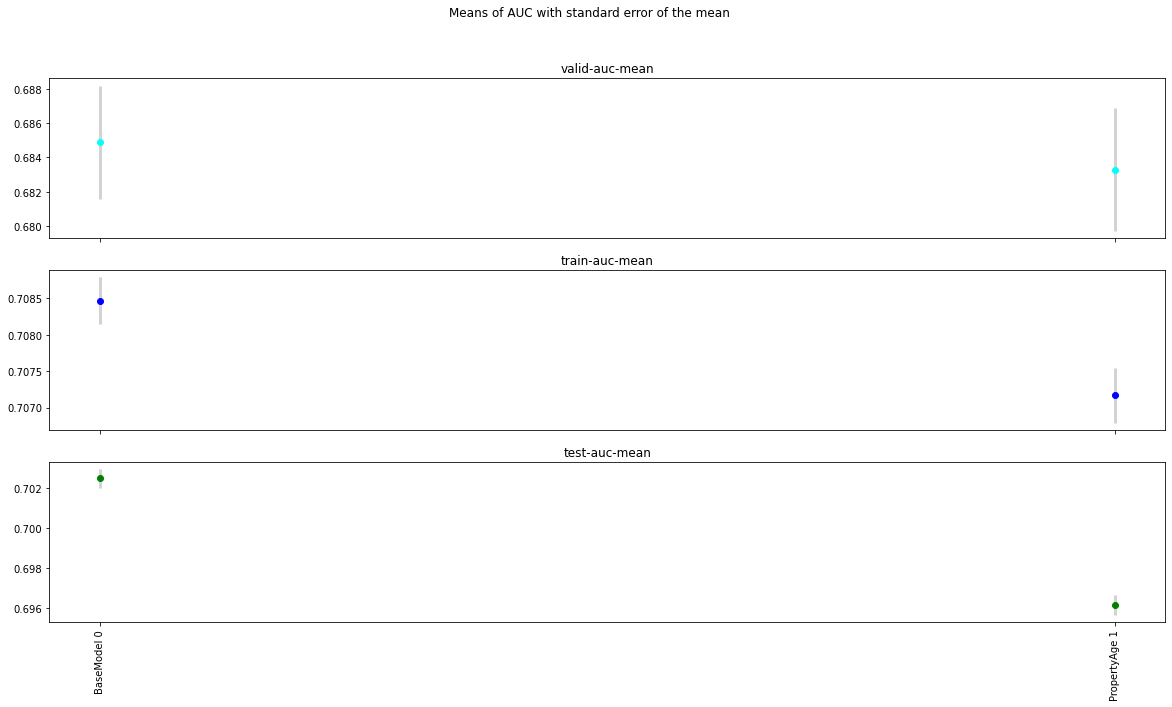

In [31]:
#Excluding from chart models which did not learn anything (0.5 is random guessing)
data = BestResults[BestResults['valid-auc-mean']>0.5].copy()
if len(ModelTestScores)>0:
    data_test = ModelTestScores[ModelTestScores['mean']>0.5].copy()
#list of models for xticks
data['xticks']=data['Model']+' '+data['ind'].astype(str) 
xticks=data['xticks'].unique().tolist()


# The x position 
r1 = np.arange(len(data))
if len(ModelTestScores)>0:
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(20,10))
else:
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(20,10))
ax = axs[0]
ax.errorbar(r1, data['valid-auc-mean'], color = 'cyan',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['valid-auc-sem'], fmt='o')
ax.set_title('valid-auc-mean')
ax = axs[1]
ax.errorbar(r1, data['train-auc-mean'],  color = 'blue',  ecolor='lightgray', elinewidth=3,capsize=0, yerr=data['train-auc-sem'],  fmt='o')
ax.set_title('train-auc-mean')
ax.set_xticks([r  for r in range(len(data))])
ax.set_xticklabels(xticks,rotation=90)
fig.suptitle('Means of AUC with standard error of the mean')
if len(data_test)>0:
    ax = axs[2]
    ax.errorbar(r1, data_test['mean'],  color = 'green',  ecolor='lightgray', elinewidth=3,capsize=0, yerr=data_test['sem'],  fmt='o')
    ax.set_title('test-auc-mean')
    ax.set_xticks([r  for r in range(len(data_test))])
    ax.set_xticklabels(xticks,rotation=90)

4. t-test
Compares the scores of individual folds in a choosen model to the rest of the models folds

In [32]:
#set a specific BaseModel name and index or just select with min or max score
#The rest of the models will be compared to baseModel and baseind
BaseModel=BestResults[BestResults['valid-auc-mean']==BestResults['valid-auc-mean'].max()]['Model'].values[0]
BaseInd=BestResults[BestResults['valid-auc-mean']==BestResults['valid-auc-mean'].max()]['ind'].values[0]
BaseModelResults=BestResults[((BestResults['Model']==BaseModel) & (BestResults['ind']==BaseInd))][folds_valid_columns].values[0].tolist()

In [33]:
#init new columns for t-test results
BestResults['t-statistic']=0.000
BestResults['pvalue']=0.000
BestResults['Comment']='Base Model'

In [34]:
#t-test for each record in BestResults
for index, model in BestResults.iterrows():
    if ((model['Model']!=BaseModel) | (model['ind']!=BaseInd)):
        AnalyzedModelResults=model[folds_valid_columns].values.tolist()
        t=stats.ttest_ind(BaseModelResults,AnalyzedModelResults)
        BestResults.at[index,'t-statistic']= t.statistic
        BestResults.at[index,'pvalue'] = t.pvalue 
        if t.pvalue>=confidence_level:
            BestResults.at[index,'Comment'] = 'No difference with %s with %s confidence level'%(BaseModel,confidence_level)
        else:
            BestResults.at[index,'Comment'] = 'There is a difference with %s with %s confidence level'%(BaseModel,confidence_level)
BestResults

,Model,ind,TotalIterations,BestIteration,train-0-fold,train-1-fold,train-2-fold,train-3-fold,train-4-fold,train-5-fold,...,valid-6-fold,valid-7-fold,valid-8-fold,valid-9-fold,valid-auc-mean,valid-auc-std,valid-auc-sem,t-statistic,pvalue,Comment
0,BaseModel,0,1170,1069,0.706434,0.709781,0.707839,0.709202,0.70888,0.709031,...,0.674756,0.685188,0.693142,0.685688,0.684884,0.010501,0.003321,0.000000,0.000000,Base Model
1,PropertyAge,1,1163,1062,0.704921,0.708554,0.706692,0.708854,0.70731,0.707417,...,0.673745,0.684495,0.692695,0.689111,0.683287,0.011341,0.003586,0.326891,0.747521,No difference with BaseModel with 0.05 confide...


In [35]:
#joining the results of the experiment with the experiment configuration
BestResults = pd.concat([BestResults, data_for_training.drop('Model',axis=1)], axis=1)
BestResults

,Model,ind,TotalIterations,BestIteration,train-0-fold,train-1-fold,train-2-fold,train-3-fold,train-4-fold,train-5-fold,...,eta,subsample,max_depth,num_round,Training_data,Testing_data,F1,F2,F3,F4
0,BaseModel,0,1170,1069,0.706434,0.709781,0.707839,0.709202,0.70888,0.709031,...,0.02,0.6,3,5000,s3://kdproperty/Data/Experiments/bf2/training/...,s3://kdproperty/Data/Experiments/bf2/testing/B...,yearbuilt,cova_deductible,sqft,water_risk_3_blk
1,PropertyAge,1,1163,1062,0.704921,0.708554,0.706692,0.708854,0.70731,0.707417,...,0.02,0.6,3,5000,s3://kdproperty/Data/Experiments/bf2/training/...,s3://kdproperty/Data/Experiments/bf2/testing/P...,cal_year-yearbuilt,cova_deductible,sqft,water_risk_3_blk


In [36]:
BestResults.columns

Index(['Model', 'ind', 'TotalIterations', 'BestIteration', 'train-0-fold',
       'train-1-fold', 'train-2-fold', 'train-3-fold', 'train-4-fold',
       'train-5-fold', 'train-6-fold', 'train-7-fold', 'train-8-fold',
       'train-9-fold', 'train-auc-mean', 'train-auc-std', 'train-auc-sem',
       'valid-0-fold', 'valid-1-fold', 'valid-2-fold', 'valid-3-fold',
       'valid-4-fold', 'valid-5-fold', 'valid-6-fold', 'valid-7-fold',
       'valid-8-fold', 'valid-9-fold', 'valid-auc-mean', 'valid-auc-std',
       'valid-auc-sem', 't-statistic', 'pvalue', 'Comment', 'objective',
       'eval_metric', 'booster', 'scale_pos_weight', 'colsample_bylevel',
       'colsample_bytree', 'eta', 'subsample', 'max_depth', 'num_round',
       'Training_data', 'Testing_data', 'F1', 'F2', 'F3', 'F4'],
      dtype='object')

In [37]:
BestResults[['Model','ind','TotalIterations','train-auc-mean','valid-auc-mean','Comment']]

,Model,ind,TotalIterations,train-auc-mean,valid-auc-mean,Comment
0,BaseModel,0,1170,0.708468,0.684884,Base Model
1,PropertyAge,1,1163,0.707169,0.683287,No difference with BaseModel with 0.05 confide...


In [38]:
#Saving into the Experiment log file models results
eu.SaveToExperimentLog(Experiments_file, '%s BestResults'%Experiment_name, BestResults)

5. Training and validation errors (output from the model) to estimate overfitting

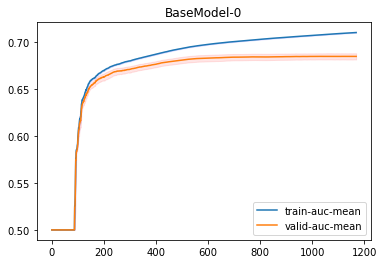

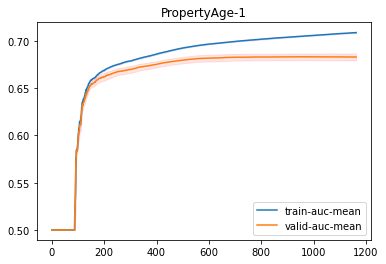

In [39]:

for index, row in data_for_training.iterrows():
    if len(CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))])>0:
        data=CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))]
        ax=data[['train-auc-mean','valid-auc-mean']].plot(title=row['Model']+'-'+str(index))
        ax.fill_between(data.index.values, (data['train-auc-mean'].values-data['train-auc-sem'].values), (data['train-auc-mean'].values + data['train-auc-sem'].values), color='b', alpha=.1)
        ax.fill_between(data.index.values, (data['valid-auc-mean'].values-data['valid-auc-sem'].values), (data['valid-auc-mean'].values + data['valid-auc-sem'].values), color='r', alpha=.1)
        
  

In [40]:
#Saving into the Experiment log file models results
#eu.SaveToExperimentLog(Experiments_file, '%s CVResults'%Experiment_name, CVResults)

In [41]:
#Saving models artifacts into the Experiment Log file
eu.SaveToExperimentLog(Experiments_file, '%s ModelFiles'%Experiment_name, ModelFiles)